In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Database connection details
db_user = 'root'
db_password = '1234'
db_host = '127.0.0.1'
db_port = '3306'
db_name = 'ecommerce'

# Create SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")




# Distinct Customer cities

In [2]:
query = "SELECT DISTINCT(customer_city) FROM customers"

# Execute the query and load the results into a Pandas DataFrame
df_cities = pd.read_sql(query, engine)

# Print the distinct cities
print("Distinct Customer Cities:")
print(df_cities)

Distinct Customer Cities:
              customer_city
0                    franca
1     sao bernardo do campo
2                 sao paulo
3           mogi das cruzes
4                  campinas
...                     ...
4114                 siriji
4115    natividade da serra
4116           monte bonito
4117             sao rafael
4118      eugenio de castro

[4119 rows x 1 columns]


# Count the number of orders placed in 2017

In [24]:
query = "Select count(order_id) as 2017_orders from orders where year(order_purchase_timestamp) = 2017 "

x = pd.read_sql(query, engine)

print(x)

   2017_orders
0        45101


# Find the total sales per category.

In [23]:
query = query = """SELECT
p.`product category`,round(SUM(o.price + o.freight_value),2) AS total_sales  
FROM order_items AS o 
JOIN products AS p USING(product_id) 
GROUP BY p.`product category`;"""

x = pd.read_sql(query, engine)

print(x)

                   product category  total_sales
0                     HEALTH BEAUTY   1441248.07
1                     sport leisure   1156656.48
2                        Cool Stuff    719329.95
3              computer accessories   1059272.40
4                   Watches present   1305541.61
..                              ...          ...
69                          flowers      1598.91
70  Kitchen portable and food coach      4278.29
71                  House Comfort 2      1170.58
72       CITTE AND UPHACK FURNITURE      5998.54
73                   cds music dvds       954.99

[74 rows x 2 columns]


# Calculate the percentage of orders that were paid in installments.

In [22]:
query = """select
sum(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)*100/(select count(order_id) from payments) as installment_percentage
from payments"""

x = pd.read_sql(query, engine)

print(x)

   installment_percentage
0                 99.9981


# Count the number of customers from each state. 

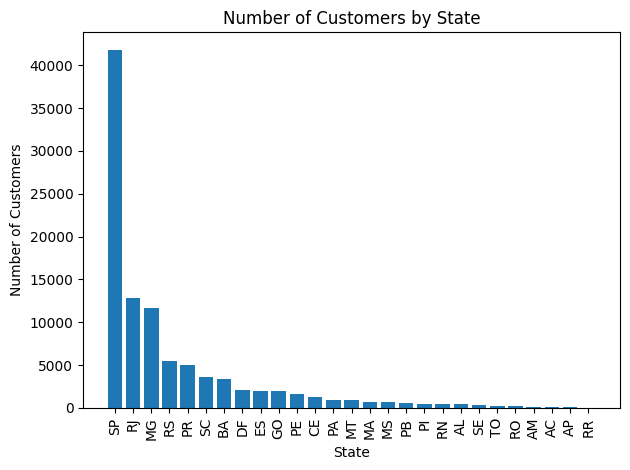

In [21]:
query = """select count(customer_id) customers,customer_state state from customers
group by state; """

x = pd.read_sql(query, engine)
x = x.sort_values(by='customers', ascending=False)
plt.bar(x['state'], x['customers'])
plt.xlabel('State') 
plt.ylabel('Number of Customers')  
plt.title('Number of Customers by State') 
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()


# Calculate the number of orders per month in 2018.

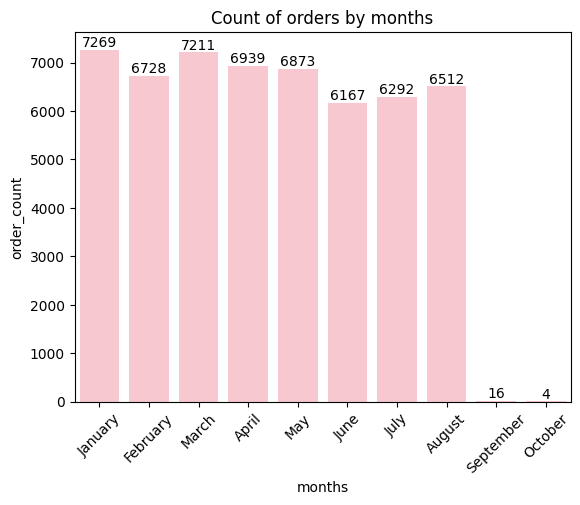

In [20]:
query = """select monthname(order_purchase_timestamp) months, count(order_id) as order_count
from orders
where year(order_purchase_timestamp) = 2018
group by months;"""

a = pd.read_sql(query, engine)
months = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October"
]
ax = sns.barplot(x = a["months"],y = a["order_count"], data = a,order= months, color = "pink")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [19]:
query = """with count_per_order as
(select o.order_id, o.customer_id, count(oi.order_id) OC
from orders o
join order_items oi
using(order_id)
group by o.order_id, o.customer_id)
select customers.customer_city,avg(count_per_order.OC) avg_orders
from customers join count_per_order
using(customer_id)
group by customers.customer_city
;  """

a = pd.read_sql(query, engine)


print(a.head(10))

         customer_city  avg_orders
0            sao paulo      1.1562
1  sao jose dos campos      1.1385
2         porto alegre      1.1749
3              indaial      1.1154
4         treze tilias      1.2727
5       rio de janeiro      1.1468
6         mario campos      1.3333
7              guariba      1.0000
8               cuiaba      1.1976
9               franca      1.2516


# Calculate the percentage of total revenue contributed by each product category.

In [17]:
query = """SELECT
    UPPER(p.`product category`) AS category,
    ROUND(
        (SUM(o.price + o.freight_value) / (SELECT SUM(o2.price) FROM order_items AS o2)) * 100,
        2
    ) AS sales_percentage
FROM
    order_items AS o
JOIN
    products AS p USING(product_id)
GROUP BY
    p.`product category`
ORDER BY
    sales_percentage DESC;


"""

x = pd.read_sql(query, engine)

print(x)



                       category  sales_percentage
0                 HEALTH BEAUTY             10.60
1               WATCHES PRESENT              9.61
2                BED TABLE BATH              9.14
3                 SPORT LEISURE              8.51
4          COMPUTER ACCESSORIES              7.79
..                          ...               ...
69                      FLOWERS              0.01
70              HOUSE COMFORT 2              0.01
71               CDS MUSIC DVDS              0.01
72  FASHION CHILDREN'S CLOTHING              0.00
73       INSURANCE AND SERVICES              0.00

[74 rows x 2 columns]


# Identify the correlation between product price and the number of times a product has been purchased.


In [12]:
query = """select p.`product category`,count(o.price) order_count, round(avg(o.price),2) avg_price
from products p join order_items o
using(product_id)
group by p.`product category`;

"""

x = pd.read_sql(query, engine)

print(x)
correlation_coefficient = np.corrcoef(x['order_count'], x['avg_price'])[0,1]
print(" correlation between product price and the number of times a product has been purchased is:",correlation_coefficient)




                   product category  order_count  avg_price
0                     HEALTH BEAUTY         9670     130.16
1                     sport leisure         8641     114.34
2                        Cool Stuff         3796     167.36
3              computer accessories         7827     116.51
4                   Watches present         5991     201.14
..                              ...          ...        ...
69                          flowers           33      33.64
70  Kitchen portable and food coach           15     264.57
71                  House Comfort 2           30      25.34
72       CITTE AND UPHACK FURNITURE           38     114.95
73                   cds music dvds           14      52.14

[74 rows x 3 columns]
 correlation between product price and the number of times a product has been purchased is: -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

                          seller_id    revenue  rn
0  7c67e1448b00f6e969d365cea6b010ab  507166.91   1
1  1025f0e2d44d7041d6cf58b6550e0bfa  308222.04   2
2  4a3ca9315b744ce9f8e9374361493884  301245.27   3
3  1f50f920176fa81dab994f9023523100  290253.42   4
4  53243585a1d6dc2643021fd1853d8905  284903.08   5


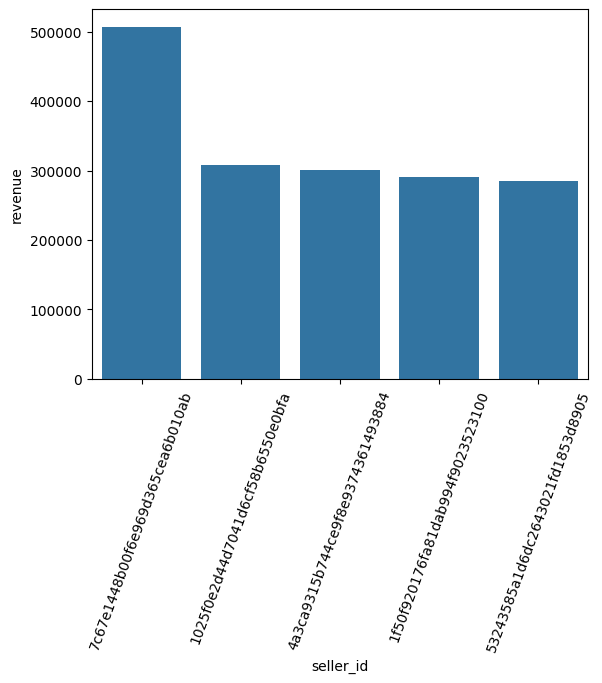

In [16]:
 query = """select *, dense_rank() over(order by revenue desc) as rn from
 (select o.seller_id,sum(p.payment_value) revenue
 from order_items o join payments p
 using(order_id)
 group by o.seller_id) a

"""

a = pd.read_sql(query, engine)

print(a.head(5))
sns.barplot(data=a.head(5),x="seller_id", y="revenue")
plt.xticks(rotation = 70)
plt.show()

#  Calculate the moving average of order values for each customer over their order history.

In [6]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
from payments p join orders o
using(order_id)) as a;;

"""

x = pd.read_sql(query, engine)

print(x)


                             customer_id order_purchase_timestamp  payment  \
0       00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1       000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
2       0001fd6190edaaf884bcaf3d49edf079      2017-02-28 11:06:43   195.42   
3       0002414f95344307404f0ace7a26f1d5      2017-08-16 13:09:20   179.35   
4       000379cdec625522490c315e70c7a9fb      2018-04-02 13:42:17   107.01   
...                                  ...                      ...      ...   
103881  fffecc9f79fd8c764f843e9951b11341      2018-03-29 16:59:26     9.49   
103882  fffeda5b6d849fbd39689bb92087f431      2018-05-22 13:36:02    63.13   
103883  ffff42319e9b2d713724ae527742af25      2018-06-13 16:57:05   214.13   
103884  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
103885  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   

        mov_avg  
0        114.74  
1         67.41  
2        

# Calculate the cumulative sales per month for each year

In [7]:
query = """select years, months,payment,sum(payment)
over(order by years, months) cum_sales from
(select year(o.order_purchase_timestamp) years
, month(o.order_purchase_timestamp) months
, round(sum(p.payment_value),2) payment
from orders o join payments p 
using(order_id)
group by years, months
order by years, months) as a;
"""
x = pd.read_sql(query, engine)
print(x)

    years  months     payment    cum_sales
0    2016       9      252.24       252.24
1    2016      10    59090.48     59342.72
2    2016      12       19.62     59362.34
3    2017       1   138488.04    197850.38
4    2017       2   291908.01    489758.39
5    2017       3   449863.60    939621.99
6    2017       4   417788.03   1357410.02
7    2017       5   592918.82   1950328.84
8    2017       6   511276.38   2461605.22
9    2017       7   592382.92   3053988.14
10   2017       8   674396.32   3728384.46
11   2017       9   727762.45   4456146.91
12   2017      10   779677.88   5235824.79
13   2017      11  1194882.80   6430707.59
14   2017      12   878401.48   7309109.07
15   2018       1  1115004.18   8424113.25
16   2018       2   992463.34   9416576.59
17   2018       3  1159652.12  10576228.71
18   2018       4  1160785.48  11737014.19
19   2018       5  1153982.15  12890996.34
20   2018       6  1023880.50  13914876.84
21   2018       7  1066540.75  14981417.59
22   2018  

# Calculate the year-over-year growth rate of total sales.

In [15]:
query = """
with a as (select year(o.order_purchase_timestamp) years
, round(sum(p.payment_value),2) payment
from orders o join payments p 
using(order_id)
group by years
order by years)

select years,round(((payment - lag(payment,1) over (order by years)) /
lag(payment,1) over(order by years)),2) *100 as yoy_percentage from a;
"""
x = pd.read_sql(query, engine)
print(x)

   years  yoy_percentage
0   2016             NaN
1   2017         12113.0
2   2018            20.0


# Identify the top 3 customers who spent the most money in each year.

   years                       customer_id  payments  ranking
0   2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.55        1
1   2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.74        2
2   2016  4a06381959b6670756de02e07b83815f   1227.78        3
3   2017  1617b1357756262bfa56ab541c47bc16  13664.08        1
4   2017  c6e2731c5b391845f6800c97401a43a9   6929.31        2
5   2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.66        3
6   2018  ec5b2ba62e574342386871631fafd3fc   7274.88        1
7   2018  f48d464a0baaea338cb25f816991ab1f   6922.21        2
8   2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.44        3


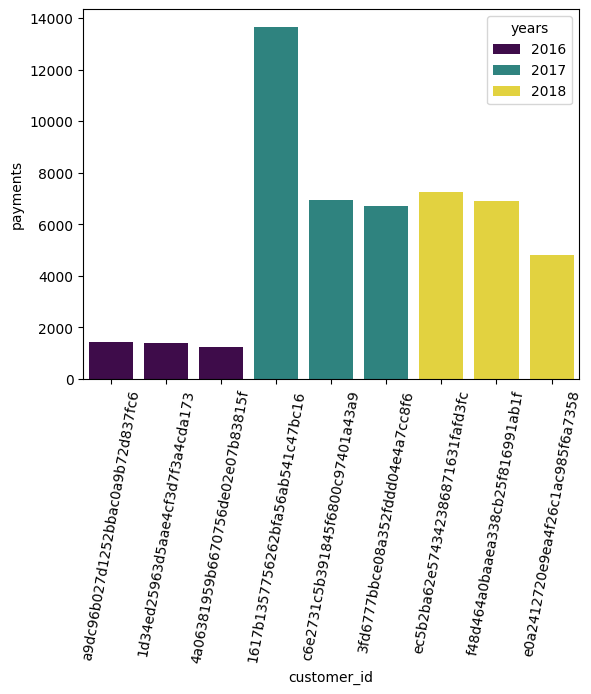

In [26]:
query = """
select years, customer_id, payments, ranking
from
(select year(o.order_purchase_timestamp) years
, o.customer_id
, sum(p.payment_value) payments,
dense_rank() over ( partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) ranking
from orders o join payments p
using (order_id)
group by years
, years
, o.customer_id) as x
where ranking<=3;
"""
a = pd.read_sql(query, engine)
print(a)
sns.barplot(x = "customer_id" , y = "payments", data = a, hue = "years", palette = "viridis")
plt.xticks(rotation = 80)
plt.show()